# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Introduction to Data Science
## Lab 6: Convolutional Neural Networks 2

**Harvard University**<br>
**Spring 2020**<br>
**Instructors:** Mark Glickman, Pavlos Protopapas, and Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Angelaki Kaxiras<br>
**Content:** Eleni Angelaki Kaxiras, Cedric Flamant, Pavlos Protopapas

---

In [16]:
# RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)


## Learning Goals

In this lab we will continue with Convolutional Neural Networks (CNNs), will look into the `tf.data` interface which enables us to build complex input pipelines for our data. We will also touch upon visualization techniques to peak into our CNN's hidden layers.

By the end of this lab, you should be able to:

- know how a CNN works from start to finish
- use `tf.data.Dataset` to import and, if needed, transform, your data for feeding into the network. Transformations might include normalization, scaling, tilting, resizing, or applying other data augmentation techniques.
- understand how `saliency maps` are implemented with code.

<a id=top></a> 

## Table of Contents

1. **Part 1**: [Beginning-to-end Convolutional Neural Networks](#part1).
2. **Part 2**: [Image Pipelines with `tf.data.Dataset`](#part2). 
3. **Part 3**: [Hidden Layer Visualization, Saliency Maps](#part3).

In [2]:
import numpy as np
from scipy.optimize import minimize
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D,\
                                    Dropout, Flatten, Activation, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, \
                                     FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
tf.keras.backend.clear_session()  # For easy reset of notebook state.
print(tf.__version__)  # You should see a > 2.0.0 here!
from tf_keras_vis.utils import print_gpus
print_gpus()

2.0.0
0 GPUs


In [4]:
## Additional Packages required if you don't already have them
# While in your conda environment,

# imageio
#       Install using "conda install imageio"
# pillow
#       Install using "conda install pillow"
# tensorflow-datasets
#       Install using "conda install tensorflow-datasets"
# tf-keras-vis
#       Install using "pip install tf-keras-vis"
# tensorflow-addons
#       Install using "pip install tensorflow-addons"

In [5]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tf_keras_vis.utils as utils
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

In [6]:
np.random.seed(109)
tf.random.set_seed(109)

## Part 0: Running on SEAS JupyterHub

**PLEASE READ**: [Instructions for Using SEAS JupyterHub](https://canvas.harvard.edu/courses/65462/pages/instructions-for-using-seas-jupyterhub?module_item_id=638544)

SEAS and FAS are providing you with a platform in AWS to use for the class (accessible from the 'Jupyter' menu link in Canvas). These are AWS p2 instances with a GPU, 10GB of disk space, and 61 GB of RAM,  for faster training for your networks. Most of the libraries such as keras, tensorflow, pandas, etc. are pre-installed. If a library is missing you may install it via the Terminal.

**NOTE: The AWS platform is funded by SEAS and FAS for the purposes of the class. It is FREE for you - not running against your personal AWS credit. For this reason you are only allowed to use it for purposes related to this course, and with prudence.**

**Help us keep this service: Make sure you stop your instance as soon as you do not need it. Your instance will terminate after 30 min of inactivity.**

![aws-dog](../images/aws-dog.jpeg)
*source: CS231n Stanford, Google Cloud Tutorial*

<a id=part1></a>

## Part 1:  Beginning-to-end Convolutional Neural Networks

![cnn](../images/CNN.png)

*image [source](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)*
<BR><BR>
We will go through the various steps of training a CNN, including:
- difference between cross-validation and validation
- specifying a loss, metrics, and an optimizer,
- performing validation,
- using callbacks, specifically `EarlyStopping`, which stops the training when training is no longer improving the validation metrics,
- learning rate significance
<BR><BR>
<div class="exercise"  style="background-color:#b3e6ff"><b>Table Exercise</b>: Use the whiteboard next to your table to draw a CNN from start to finish as per the instructions. We will then draw it together in class.</div>   

<a id=part2></a> [Back to Table of Contents](#top)

## Part 2:  Image Preprocessing: Using `tf.data.Dataset`

In [7]:
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

 `tf.data` API in `tensorflow` enables you to build complex **input pipelines** from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. 

The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths. The `tf.data API` makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

The `tf.data API` introduces a `tf.data.Dataset` that represents a sequence of **elements**, consistινγ of one or more **components**. For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.

To create an input pipeline, you must start with a data **source**. For example, to construct a Dataset from data in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`. Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use `tf.data.TFRecordDataset()`.

The Dataset object is a Python iterable. You may view its elements using a for loop:

## We can use test set as validation set
## You don't have test set when you use it for validation

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

for elem in dataset:
    print(elem.numpy())

[4 3 1 9 7 4 8 9 4 6]
[9 6 2 2 6 4 7 2 9 8]
[5 7 5 4 8 5 6 4 8 4]
[6 2 2 2 6 6 4 2 2 2]


Once you have a Dataset object, you can **transform** it into a new Dataset by chaining method calls on the `tf.data.Dataset` object. For example, you can apply per-element transformations such as `Dataset.map()`, and multi-element transformations such as `Dataset.batch()`. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for `tf.data.Dataset` for a complete list of transformations.

The `map` function takes a function and returns a new and augmented dataset. 

In [9]:
dataset = dataset.map(lambda x: x*2) 
for elem in dataset:
    print(elem.numpy())

[ 8  6  2 18 14  8 16 18  8 12]
[18 12  4  4 12  8 14  4 18 16]
[10 14 10  8 16 10 12  8 16  8]
[12  4  4  4 12 12  8  4  4  4]


Datasets are powerful objects because they are effectively dictionaries that can store tensors and other data such as the response variable. We can also construct them by passing small sized `numpy` arrays, such as in the following example.

Tensorflow has a plethora of them:

In [10]:
# uncomment to see available datasets
# tfds.list_builders()

#### `mnist` dataset

In [11]:
# load mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [12]:
# take only 10 images for simplicity
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

(28, 28)
(28, 28)


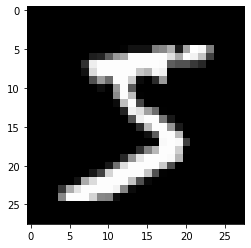

In [13]:
# In case you want to retrieve the images/numpy arrays
for element in iter(train_dataset.take(1)):
    image = element[0].numpy()
    print(image.shape)
    print(image.shape)
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.show()

Once you have your Model, you may pass a Dataset instance directly to the methods `fit()`, `evaluate()`, and `predict()`. The difference with the way we have been previously using these methods is that we are not passing the images and labels separately. They are now both in the Dataset object.

```
model.fit(train_dataset, epochs=3)

model.evaluate(test_dataset)
```

#### Data Augmentation

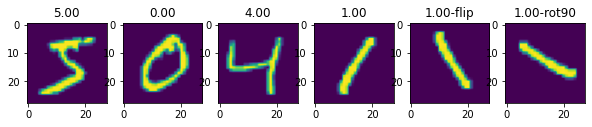

In [14]:
fig, axes = plt.subplots(1,6, figsize=(10,3))
for i, (image, label) in enumerate(train_dataset.take(4)):
    axes[i].imshow(image)
    axes[i].set_title(f'{label:.2f}')
image_flip_up = tf.image.flip_up_down(np.expand_dims(image, axis=2)).numpy()
image_rot_90 = tf.image.rot90(np.expand_dims(image, axis=2), k=1).numpy()
axes[4].imshow(image_flip_up.reshape(28,-1))
axes[4].set_title(f'{label:.2f}-flip')
axes[5].imshow(image_rot_90.reshape(28,-1))
axes[5].set_title(f'{label:.2f}-rot90')
plt.show();

#### Note:

The tf.data API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable. You also have the option to use the `keras` [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), that accepts `numpy` arrays, instead of the Dataset. We think it's good for you to learn to use Datasets.

As a general rule, for input to NNs, Tensorflow recommends that you use `numpy` arrays if your data is small and fit in memory, and `tf.data.Datasets` otherwise.

#### References:
1. `tf.data.Dataset` [Documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).
2. Import [`numpy` arrays in Tensorflow](https://www.tensorflow.org/tutorials/load_data/numpy)

### The Street View House Numbers (SVHN) Dataset

We will play with the SVHN real-world image dataset. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 

All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, $X(:,:,:,i)$ gives the i-th 32-by-32 RGB image, with class label $y(i)$.

![svhn](../images/svhn.png)

*Yuval Netzer, Tao Wang, Adam Coates, Alessandro Bissacco, Bo Wu, Andrew Y. Ng Reading Digits in Natural Images with Unsupervised Feature Learning NIPS Workshop on Deep Learning and Unsupervised Feature Learning 2011.*

In [15]:
# Will take some time but will only load once
train_svhn_cropped, test_svhn_cropped = tfds.load('svhn_cropped', split=['train', 'test'], shuffle_files=False)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset svhn_cropped downloaded and prepared to /Users/asanneh/tensorflow_datasets/svhn_cropped/1.0.0. Subsequent calls will reuse this data.


In [17]:
isinstance(train_svhn_cropped, tf.data.Dataset)

True

In [18]:
# # convert to numpy if needed
features = next(iter(train_svhn_cropped))
images = features['image'].numpy()
labels = features['label'].numpy()
images.shape, labels.shape

((32, 32, 3), ())

In [19]:
for i, element in enumerate(train_svhn_cropped):
    if i==1: break;
    image = element['image'] 
    label = element['label']
    print(label)

tf.Tensor(5, shape=(), dtype=int64)


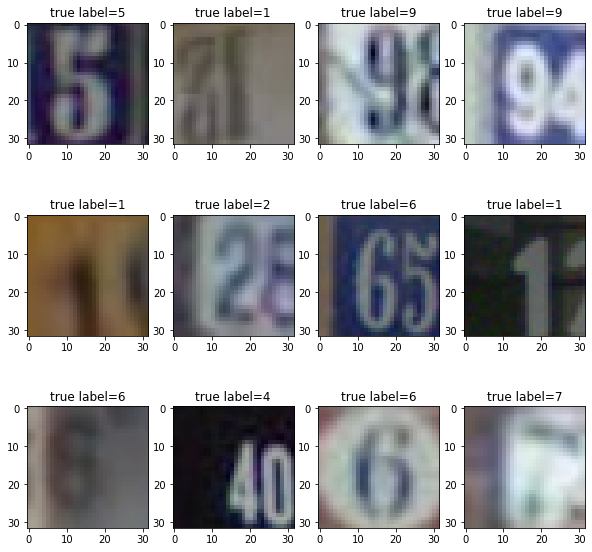

In [20]:
# batch_size indicates that the dataset should be divided in batches 
# each consisting of 4 elements (a.k.a images and their labels)
# take_size chooses a number of these batches, e.g. 3 of them for display

batch_size = 4
take_size = 3

# Plot
fig, axes = plt.subplots(take_size,batch_size, figsize=(10,10))
for i, element in enumerate(train_svhn_cropped.batch(batch_size).take(take_size)):
    for j in range(4):
        image = element['image'][j]
        label = element['label'][j]
        axes[i][j].imshow(image)
        axes[i][j].set_title(f'true label={label:d}')

Here we convert from a collection of dictionaries to a collection of tuples. We will still have a `tf.data.Dataset`

In [21]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def normalize_dataset(element):
    img = element['image']
    lbl = element['label']
    return normalize_image(img), lbl

In [22]:
train_svhn = train_svhn_cropped.map(normalize_dataset)
test_svhn = test_svhn_cropped.map(normalize_dataset)

In [23]:
isinstance(train_svhn, tf.data.Dataset)

True

#### Define our CNN model 

In [24]:
n_filters = 16
input_shape = (32, 32, 3)

svhn_model = Sequential() 
svhn_model.add(Conv2D(n_filters, (3, 3), activation='relu', input_shape=input_shape))
svhn_model.add(MaxPooling2D((2, 2)))
svhn_model.add(Conv2D(n_filters*2, (3, 3), activation='relu')) 
svhn_model.add(MaxPooling2D((2, 2)))
svhn_model.add(Conv2D(n_filters*4, (3, 3), activation='relu'))
svhn_model.add(Flatten())
svhn_model.add(Dense(n_filters*2, activation='relu'))
svhn_model.add(Dense(10, activation='softmax'))
svhn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                3

In [25]:
loss = keras.losses.sparse_categorical_crossentropy # we use this because we did not 1-hot encode the labels
optimizer = Adam(lr=0.001)
metrics = ['accuracy'] 

# Compile model
svhn_model.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=metrics)

#### With Early Stopping

In [ ]:
%%time
batch_size = 64
epochs=15

callbacks = [ 
            keras.callbacks.EarlyStopping(
            # Stop training when `val_accuracy` is no longer improving
            monitor='val_accuracy',
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1)
            ]

history = svhn_model.fit(train_svhn.batch(batch_size), #.take(50), # change 50 only
                         epochs=epochs,
                         callbacks=callbacks,
                         validation_data=test_svhn.batch(batch_size)) #.take(50))

In [ ]:
def print_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot((history.history['accuracy']), 'b', label='train')
    ax.plot((history.history['val_accuracy']), 'g' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Accuracy', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot((history.history['loss']), 'b', label='train')
    ax.plot((history.history['val_loss']), 'g' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Loss', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)
    plt.show();
    
print_history(history)

In [ ]:
svhn_model.save('svhn_good.h5')

#### Too High Learning Rate

In [ ]:
loss = keras.losses.sparse_categorical_crossentropy 
optimizer = Adam(lr=0.5) # really big learning rate
metrics = ['accuracy'] 

# Compile model
svhn_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
%%time
batch_size = 64
epochs=10

history = svhn_model.fit(train_svhn.batch(batch_size), #.take(50), # change 50 to see the difference
                         epochs=epochs,
                         validation_data=test_svhn.batch(batch_size)) #.take(50))

In [ ]:
print_history(history)
fig.savefig('../images/train_high_lr.png')

#### Too Low Learning Rate

Experiment with the learning rate using a small sample of the training set by using .take(num) which takes only `num` number of samples.
```
history = svhn_model.fit(train_svhn.batch(batch_size).take(50))
```

In [ ]:
#loss = keras.losses.categorical_crossentropy
loss = keras.losses.sparse_categorical_crossentropy # we use this because we did not 1-hot encode the labels
optimizer = Adam(lr=1e-5) # very low learning rate
metrics = ['accuracy'] 

# Compile model
svhn_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
%%time
batch_size = 32
epochs=10

history = svhn_model.fit(train_svhn.batch(batch_size).take(50),
                         epochs=epochs,
                         validation_data=test_svhn.batch(batch_size)) #.take(50))

In [ ]:
print_history(history)
fig.savefig('../images/train_50.png')

#### Changing the batch size

In [ ]:
#loss = keras.losses.categorical_crossentropy
loss = keras.losses.sparse_categorical_crossentropy # we use this because we did not 1-hot encode the labels
optimizer = Adam(lr=0.001)
metrics = ['accuracy'] 

# Compile model
svhn_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
%%time
batch_size = 2
epochs=5

history = svhn_model.fit(train_svhn.batch(batch_size), 
                         epochs=epochs,
                         validation_data=test_svhn.batch(batch_size)) 

In [ ]:
print_history(history)

<a id=part3></a> [Back to Table of Contents](#top)
## Part 3: Hidden Layer Visualization, Saliency Maps

[Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)

It is often said that Deep Learning Models are black boxes. But we can peak into these boxes. 

#### Let's train a small model on MNIST

In [ ]:
from tensorflow.keras.datasets import mnist
# load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train.min(), x_train.max()

In [ ]:
x_train = x_train.reshape((60000, 28, 28, 1)) # Reshape to get third dimension
x_test = x_test.reshape((10000, 28, 28, 1)) 

x_train = x_train.astype('float32') / 255 # Normalize between 0 and 1
x_test = x_test.astype('float32') / 255 

# Convert labels to categorical data 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train.min(), x_train.max()

In [ ]:
# (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data(
#                                                             path='mnist.npz')
x_train.shape

In [ ]:
class_idx = 0
indices = np.where(y_test[:, class_idx] == 1.)[0]

# pick some random input from here.
idx = indices[0]
img = x_test[idx]

In [ ]:
# pick some random input from here.
idx = indices[0]

# Lets sanity check the picked image.
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

#plt.imshow(test_images[idx][..., 0])
img = x_test[idx] * 255 
img = img.astype('float32')
img = np.squeeze(img) # trick to reduce img from (28,28,1) to (28,28)
plt.imshow(img, cmap='gray');

In [ ]:
input_shape=(28, 28, 1)
num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))
model.summary()

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
num_samples = x_train.shape[0]
num_samples

In [ ]:
%%time
batch_size = 32
epochs = 10

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2,
          shuffle=True)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Let's look at the layers with `tf.keras.viz` 

https://pypi.org/project/tf-keras-vis/

And an example: https://github.com/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb

We can identify layers by their layer id:

In [ ]:
# Alternatively we can specify layer_id as -1 since it corresponds to the last layer.
layer_id = 0
model.layers[layer_id].name, model.layers[-2].name

Or you may look at their output

In [ ]:
output = [model.layers[layer_id].output]
output

In [ ]:
# # You may also replace part of your NN with other parts,
# # e.g. replace the activation function of the last layer
# # with a linear one

# model.layers[-1].activation = tf.keras.activations.linear

Generate Feature Maps

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output]) 
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

In [ ]:
# Choose an arbitrary image
image_id = 67
img = x_test[image_id,:,:,:]
img.shape

In [ ]:
img_to_show = np.squeeze(img)
plt.imshow(img_to_show, cmap='gray')

In [ ]:
# Was this successfully predicted?
img_batch = (np.expand_dims(img,0))
print(img_batch.shape)
predictions_single = model.predict(img_batch)
print(f'Prediction is: {np.argmax(predictions_single[0])}') 

In [ ]:
# layer id should be for a Conv layer, a Flatten will not do
maps = get_feature_maps(model, layer_id, img)# [0:10]
maps.shape

In [ ]:
# Plot just a subset
maps = get_feature_maps(model, layer_id, img)[0:10]

fig, ax = plt.subplots()
img = np.squeeze(img)
ax.imshow(img + 0.5)
label = y_test[image_id,:]
label = int(np.where(label == 1.)[0])

ax.set_title(f'true label = {label}')

f, ax = plt.subplots(3,3, figsize=(8,8))
for i, axis in enumerate(ax.ravel()):
    axis.imshow(maps[i], cmap='gray')

### `tf_keras_vis.gradcam.Gradcam`

[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

In [ ]:
#from tensorflow.keras import backend as K
# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

In [ ]:
#img_batch = (np.expand_dims(img,0))
# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(model, model_modifier)

# Define loss function. Pass it the correct class label.
loss = lambda output: tf.keras.backend.mean(output[:, tf.argmax(y_test[image_id])])

In [ ]:
# Generate saliency map
print(img_batch.shape)

In [ ]:
saliency_map = saliency(loss, img_batch)

saliency_map = normalize(saliency_map)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) #, subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(saliency_map[i], cmap='jet')
ax[1].imshow(img);

In [ ]:
# from matplotlib import cm
# from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model, model_modifier)

# Generate heatmap with GradCAM
cam = gradcam(loss, img_batch)
cam = normalize(cam)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                     subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)